In [0]:
from google.colab import files
uploaded = files.upload()

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
all = pd.concat([train, test], axis =0).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [2]:
all["Title"] = all["Name"].apply(lambda x:re.split("[,.]", x)[1])
all["Cabin"].fillna("U", inplace=True)
all["Cabin"] = all["Cabin"].apply(lambda x:x[0])
all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,U,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,U,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,U,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [0]:
all["col_Pclass_Title"] = all.apply(lambda x:"{}_{}".format(x["Pclass"], x["Title"]), axis=1)

age_mean = all.groupby("col_Pclass_Title")["Age"].mean()

col_mask = all["Age"].map(lambda x: np.isnan(x))

all.loc[col_mask, "Age"] = all.loc[col_mask, "col_Pclass_Title"].map(age_mean)

all.drop(columns="col_Pclass_Title", inplace=True)

In [4]:
all.groupby(["Title"], as_index=False)["Age"].mean()

,Title,Age
0,Capt,70.000000
1,Col,54.000000
2,Don,40.000000
3,Dona,39.000000
4,Dr,43.825000
5,Jonkheer,38.000000
6,Lady,48.000000
7,Major,48.500000
8,Master,5.562295
9,Miss,21.001247


In [0]:
all["Age"].fillna(28, inplace=True)

In [6]:
all.groupby(["Pclass"], as_index=False)["Fare"].mean()

,Pclass,Fare
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [7]:
all.Fare[1043] = 13.302889

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
all["Embarked"] = all["Embarked"].fillna("S")
all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,U,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,U,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,U,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [9]:
cols = ["Sex","Embarked","Cabin","Title"]
all_to_cat = pd.get_dummies(all, columns=cols)
print(all_to_cat.shape)

(1309, 41)


In [0]:
data_counts = all['Title'].value_counts()
Title_to_drop = data_counts[data_counts < 3].index.tolist()

to_drop_list = []
target_col = "Title"

for each_data in Title_to_drop:
    col_name = "{}_{}".format(target_col, each_data)
    to_drop_list.append(col_name)
    
all_to_cat.drop(columns=to_drop_list, inplace=True)

In [11]:
to_drop = ["PassengerId", "Name", "Ticket"]

all_to_cat.drop(columns=to_drop, inplace=True)
print(all_to_cat.shape)

(1309, 27)


In [12]:
all_to_cat["Pclass"] /= 3
all_to_cat["Age"] /= 80
all_to_cat["SibSp"] /= 8
all_to_cat["Parch"] /= 9
all_to_cat["Fare"] /= 512.3292

all_to_cat.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Title_ Col,Title_ Dr,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_ Rev
0,0.2750,0.014151,0.0,1.000000,0.125,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,0.4750,0.139136,0.0,0.333333,0.125,1.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.3250,0.015469,0.0,1.000000,0.000,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0.4375,0.103644,0.0,0.333333,0.125,1.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.4375,0.015713,0.0,1.000000,0.000,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [13]:
train_to_cat = all_to_cat.iloc[0:891, :]
train_to_cat.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Title_ Col,Title_ Dr,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_ Rev
0,0.2750,0.014151,0.0,1.000000,0.125,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,0.4750,0.139136,0.0,0.333333,0.125,1.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.3250,0.015469,0.0,1.000000,0.000,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0.4375,0.103644,0.0,0.333333,0.125,1.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.4375,0.015713,0.0,1.000000,0.000,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [14]:
train_train = train_to_cat.drop(["Survived"], axis=1)
train_train.head()

,Age,Fare,Parch,Pclass,SibSp,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Title_ Col,Title_ Dr,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_ Rev
0,0.2750,0.014151,0.0,1.000000,0.125,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,0.4750,0.139136,0.0,0.333333,0.125,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.3250,0.015469,0.0,1.000000,0.000,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0.4375,0.103644,0.0,0.333333,0.125,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.4375,0.015713,0.0,1.000000,0.000,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [0]:
target = train_to_cat["Survived"].values
features = train_train.values

In [0]:
x_train, x_test, t_train, t_test = train_test_split(features, target, test_size =0.3, random_state = 0)

In [17]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
train_data = lgb.Dataset(x_train, label=t_train)
eval_data = lgb.Dataset(x_test, label=t_test, reference=train_data)

In [0]:
param1 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 20,
    'feature_fraction': 1.0,
    'num_leaves': 31,
    'max_depth': 7,
    'n_estimators': 100,
}

In [0]:
param2 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 100,
    'max_depth': 10,
    'n_estimators': 60,
}

In [0]:
param3 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 200,
    'max_depth': 20,
    'n_estimators': 60,
}

In [0]:
param4 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 300,
    'max_depth': 30,
    'n_estimators': 60,
}

In [0]:
param5 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.05,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 400,
    'max_depth': 40,
    'n_estimators': 50,
}

In [0]:
param6 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.05,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 500,
    'max_depth': 50,
    'n_estimators': 50,
}

In [0]:
param7 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.05,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 600,
    'max_depth': 60,
    'n_estimators': 50,
}

In [0]:
param8 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.05,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 700,
    'max_depth': 70,
    'n_estimators': 50,
}

In [0]:
param9 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.03,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 800,
    'max_depth': 80,
    'n_estimators': 40,
}

In [0]:
param10 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.03,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 900,
    'max_depth': 90,
    'n_estimators': 40,
}

In [29]:
gbm1 = lgb.train(
    param1,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20,
)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's binary_logloss: 0.404132
[40]	valid_0's binary_logloss: 0.38445
[60]	valid_0's binary_logloss: 0.396426
[80]	valid_0's binary_logloss: 0.410016
[100]	valid_0's binary_logloss: 0.417354
Did not meet early stopping. Best iteration is:
[38]	valid_0's binary_logloss: 0.383438


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [30]:
gbm2 = lgb.train(
    param2,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20,
)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's binary_logloss: 0.403104
[40]	valid_0's binary_logloss: 0.384978
[60]	valid_0's binary_logloss: 0.39452
Did not meet early stopping. Best iteration is:
[34]	valid_0's binary_logloss: 0.382935


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [31]:
gbm3 = lgb.train(
    param3,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20,
)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's binary_logloss: 0.402804
[40]	valid_0's binary_logloss: 0.387252
[60]	valid_0's binary_logloss: 0.395064
Did not meet early stopping. Best iteration is:
[41]	valid_0's binary_logloss: 0.38498


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [32]:
gbm4 = lgb.train(
    param4,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20,
)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[20]	valid_0's binary_logloss: 0.402804
[40]	valid_0's binary_logloss: 0.387252
[60]	valid_0's binary_logloss: 0.395064
Did not meet early stopping. Best iteration is:
[41]	valid_0's binary_logloss: 0.38498


In [33]:
gbm5 = lgb.train(
    param5,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20,
)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[20]	valid_0's binary_logloss: 0.457919
[40]	valid_0's binary_logloss: 0.406726
Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.398795


In [34]:
gbm6 = lgb.train(
    param6,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20,
)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[20]	valid_0's binary_logloss: 0.457919
[40]	valid_0's binary_logloss: 0.406726
Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.398795


In [35]:
gbm7 = lgb.train(
    param7,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20,
)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[20]	valid_0's binary_logloss: 0.457919
[40]	valid_0's binary_logloss: 0.406726
Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.398795


In [36]:
gbm8 = lgb.train(
    param8,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20,
)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[20]	valid_0's binary_logloss: 0.457919
[40]	valid_0's binary_logloss: 0.406726
Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.398795


In [41]:
gbm9 = lgb.train(
    param9,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20,
)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's binary_logloss: 0.50444
[40]	valid_0's binary_logloss: 0.444821
Did not meet early stopping. Best iteration is:
[40]	valid_0's binary_logloss: 0.444821


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [42]:
gbm10 = lgb.train(
    param10,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20,
)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's binary_logloss: 0.50444
[40]	valid_0's binary_logloss: 0.444821
Did not meet early stopping. Best iteration is:
[40]	valid_0's binary_logloss: 0.444821


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [0]:
test_to_cat = all_to_cat.iloc[891:, :]
test_test = test_to_cat.drop(["Survived"], axis=1)

In [0]:
test_features = test_test.values

In [45]:
pred1 = gbm1.predict(test_features)
pred2 = gbm2.predict(test_features) 
pred3 = gbm3.predict(test_features)
pred5 = gbm5.predict(test_features)
pred9 = gbm9.predict(test_features)
print(pred1)
print(pred2)
print(pred3)
print(pred5)
print(pred9)

[0.06703583 0.39529158 0.03376029 0.22169699 0.49608024 0.19207886
 0.51433002 0.23122995 0.84743183 0.0326693  0.07400317 0.08006122
 0.94572294 0.0252844  0.95374849 0.93118449 0.1402043  0.18990642
 0.34337561 0.53932746 0.08191271 0.63173928 0.96881923 0.16497355
 0.94060392 0.04645717 0.9686836  0.18990642 0.4606397  0.05824561
 0.05523749 0.04408283 0.50820206 0.42118514 0.37024788 0.17556527
 0.46787169 0.50841095 0.0732695  0.30412737 0.09755506 0.4132222
 0.06501642 0.9020145  0.95089881 0.07838134 0.32363608 0.1416509
 0.96480705 0.62481248 0.21964412 0.24168989 0.88340403 0.63634222
 0.45911497 0.07850494 0.06641039 0.28534979 0.0664148  0.97740239
 0.0731795  0.34465092 0.12150013 0.81080074 0.75175614 0.93404994
 0.82936402 0.05767566 0.59857163 0.86298684 0.80180414 0.06074623
 0.31750934 0.57405517 0.94992988 0.59106969 0.09873853 0.75560244
 0.19606148 0.80180414 0.87287174 0.15992838 0.09775516 0.07400317
 0.32671076 0.15192498 0.63677702 0.46787169 0.53633774 0.891819

In [46]:
pred101 = np.where(pred1 < 0.5, 0, 1)
pred201 = np.where(pred2 < 0.5, 0, 1)
pred301 = np.where(pred3 < 0.5, 0, 1)
pred501 = np.where(pred5 < 0.5, 0, 1)
pred901 = np.where(pred9 < 0.5, 0, 1)
print(pred101)
print(pred201)
print(pred301)
print(pred501)
print(pred901)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1
 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]
[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1
 

In [0]:
PassengerId = np.array(test["PassengerId"]).astype(int)
                            
my_solution1 = pd.DataFrame(pred101, PassengerId, columns = ["Survived"])
                            
my_solution1.to_csv("Solution8_2_1.csv", index_label = ["PassengerId"])

my_solution2 = pd.DataFrame(pred201, PassengerId, columns = ["Survived"])
                            
my_solution2.to_csv("Solution8_2_2.csv", index_label = ["PassengerId"])

my_solution3 = pd.DataFrame(pred301, PassengerId, columns = ["Survived"])
                            
my_solution3.to_csv("Solution8_2_3.csv", index_label = ["PassengerId"])

my_solution5 = pd.DataFrame(pred501, PassengerId, columns = ["Survived"])
                            
my_solution5.to_csv("Solution8_2_5.csv", index_label = ["PassengerId"])

my_solution9 = pd.DataFrame(pred901, PassengerId, columns = ["Survived"])
                            
my_solution9.to_csv("Solution8_2_9.csv", index_label = ["PassengerId"])

In [0]:
from google.colab import files
files.download("Solution8_2_1.csv")
files.download("Solution8_2_2.csv")
files.download("Solution8_2_3.csv")
files.download("Solution8_2_5.csv")
files.download("Solution8_2_9.csv")

## 結果

* 1   77.033%
* 2   77.990%
*3  76.076%
*5  78.468%
*9   79.904%

9惜しい...！！

In [50]:
gbm9_2 = lgb.train(
    param9,
    train_data,
    valid_sets=eval_data,
    num_boost_round=40,
    verbose_eval=5,
)

[5]	valid_0's binary_logloss: 0.604092
[10]	valid_0's binary_logloss: 0.563034
[15]	valid_0's binary_logloss: 0.530106
[20]	valid_0's binary_logloss: 0.50444
[25]	valid_0's binary_logloss: 0.484815
[30]	valid_0's binary_logloss: 0.467205
[35]	valid_0's binary_logloss: 0.45494
[40]	valid_0's binary_logloss: 0.444821


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [51]:
pred9_2 = gbm9_2.predict(test_features)
pred9_2

array([0.1528526 , 0.41149786, 0.15957574, 0.22043682, 0.53991243,
       0.19485941, 0.5583965 , 0.29831388, 0.64715826, 0.15557951,
       0.15350916, 0.15494934, 0.79099269, 0.13150956, 0.77557674,
       0.7584811 , 0.16400909, 0.22679844, 0.39667065, 0.50481384,
       0.23959284, 0.50435267, 0.76315305, 0.27936676, 0.7675086 ,
       0.13053159, 0.80630061, 0.22604887, 0.44654857, 0.18206946,
       0.13150956, 0.17955732, 0.4703943 , 0.4703943 , 0.45530985,
       0.2149862 , 0.50613556, 0.52375373, 0.17729802, 0.26427116,
       0.1859585 , 0.36186586, 0.18793469, 0.67331687, 0.7725562 ,
       0.17269973, 0.36523419, 0.20326261, 0.78170541, 0.49718955,
       0.45056674, 0.22584486, 0.71697531, 0.51215733, 0.33704825,
       0.30258389, 0.13951228, 0.32563823, 0.16270024, 0.80599824,
       0.18541376, 0.29974475, 0.20853689, 0.69888297, 0.65902628,
       0.74567178, 0.70098666, 0.18041474, 0.50498822, 0.7119431 ,
       0.65591099, 0.15463509, 0.41967586, 0.50933422, 0.76654

In [52]:
pred901_2 = np.where(pred9_2 < 0.5, 0, 1)
pred901_2

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [0]:
my_solution9_2 = pd.DataFrame(pred901_2, PassengerId, columns = ["Survived"])

my_solution9_2.to_csv("Solution8_2_9_2.csv", index_label = ["PassengerId"])

In [0]:
files.download("Solution8_2_9_2.csv")

79.904%...！！

In [0]:
param9_3 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.03,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 800,
    'max_depth': 80,
    'n_estimators': 100,
}

In [57]:
gbm9_3 = lgb.train(
    param9_3,
    train_data,
    valid_sets=eval_data,
    num_boost_round=500,
    verbose_eval=20,
)

[20]	valid_0's binary_logloss: 0.50444
[40]	valid_0's binary_logloss: 0.444821
[60]	valid_0's binary_logloss: 0.416619
[80]	valid_0's binary_logloss: 0.398399
[100]	valid_0's binary_logloss: 0.392926


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [58]:
pred9_3 = gbm9_3.predict(test_features)
pred9_3

array([0.0949215 , 0.35675745, 0.05283515, 0.24733877, 0.57307162,
       0.18453363, 0.55707991, 0.25322854, 0.77831492, 0.04576956,
       0.08392083, 0.10875018, 0.94338532, 0.03950543, 0.93632946,
       0.90504634, 0.10049163, 0.20582418, 0.36459059, 0.51548954,
       0.10422143, 0.6279213 , 0.94214191, 0.19599289, 0.92028014,
       0.04664336, 0.95428828, 0.20512553, 0.47325604, 0.06964145,
       0.05760706, 0.05302218, 0.49867871, 0.44419106, 0.43703375,
       0.15910829, 0.49606541, 0.56415332, 0.08362982, 0.26369076,
       0.13172924, 0.42652992, 0.12455252, 0.83872924, 0.9357411 ,
       0.09038717, 0.40405142, 0.13316676, 0.94366752, 0.55705155,
       0.34800173, 0.20164267, 0.86402505, 0.65143691, 0.39785664,
       0.12160363, 0.0679533 , 0.24464881, 0.0763142 , 0.96201282,
       0.08651992, 0.31420646, 0.11302848, 0.82979959, 0.66632421,
       0.91143565, 0.84618556, 0.13230706, 0.59801059, 0.81373873,
       0.76773763, 0.06846922, 0.35141484, 0.57074557, 0.92355

In [59]:
pred901_3 = np.where(pred9_3 < 0.5, 0, 1)
pred901_3

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [0]:
my_solution9_3 = pd.DataFrame(pred901_3, PassengerId, columns = ["Survived"])

my_solution9_3.to_csv("Solution8_2_9_3.csv", index_label = ["PassengerId"])

files.download("Solution8_2_9_3.csv")

80.382%！
ついに8割超えた！！！

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

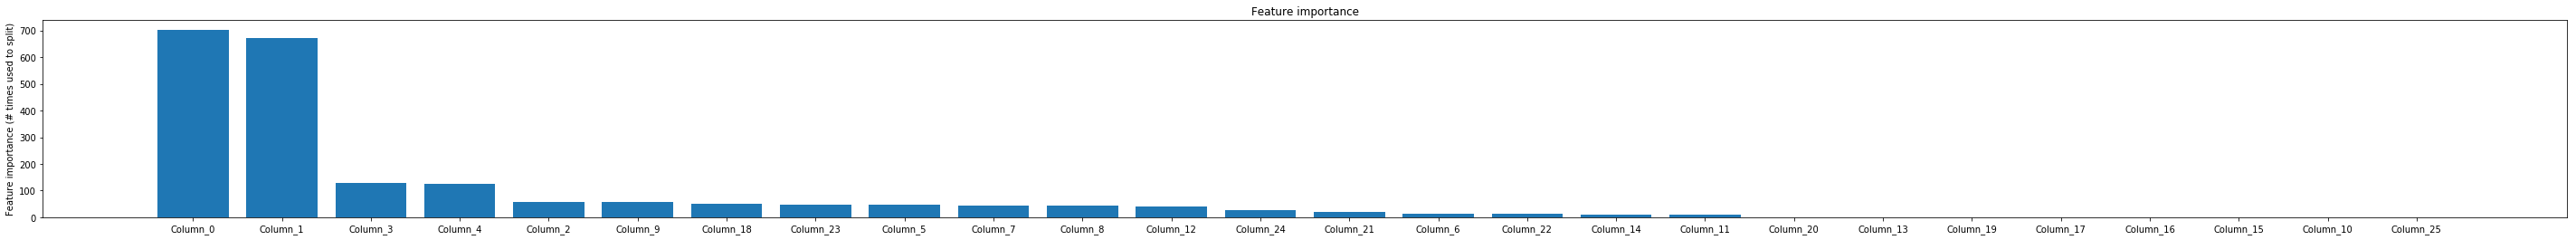

In [64]:
fig, axs = plt.subplots(figsize=[50, 4])
importances = pd.DataFrame({'features': gbm9_3.feature_name(), 
                            'importance': gbm9_3.feature_importance()}).sort_values('importance', ascending=False)
axs.bar(x=np.arange(len(importances)), height=importances['importance'])
axs.set_xticks(np.arange(len(importances)))
axs.set_xticklabels(importances['features'])
axs.set_ylabel('Feature importance (# times used to split)')
axs.set_title('Feature importance')

plt.show()

重要度は順に年齢、料金、チケットクラス、同乗している兄弟/配偶者の数、同乗している親/子の数、出港地S、客室番号の欠損、Mrの敬称、女性であること、出港地C、出港地Q、客室番号C、となった。